# Physics767 Execrcies sheet 2 Leonhard Moske

## Exercise 8

Show that the momentum states are eigenstates of the translation operator.

$
T \ket{\psi_{k,n}} = T \frac{1}{\mathcal{N}_{k,n}} \sum_{r=1}^{L}e^{ikr}T^r\ket{\text{rep}(m_1,m_2,...m_L)}
$

$
T \ket{\psi_{k,n}} =  \frac{1}{\mathcal{N}_{k,n}} \sum_{r=1}^{L}e^{ikr}T^{r+1}\ket{\text{rep}(m_1,m_2,...m_L)}
$

$
T \ket{\psi_{k,n}} = \frac{1}{\mathcal{N}_{k,n}} \sum_{r=2}^{L+1}e^{ik(r-1)}T^r\ket{\text{rep}(m_1,m_2,...m_L)}
$

$
T \ket{\psi_{k,n}} = \frac{e^{-ik}}{\mathcal{N}_{k,n}} \sum_{r=2}^{L+1}e^{ikr}T^r\ket{\text{rep}(m_1,m_2,...m_L)}
$

take a look at the last term of the sum:
$
e^{ik(L+1)}T^{L+1}
$

$
e^{ikL} = 1 
$

$
T^L = \mathcal{1}
$
so the last element can be shifted to the front

$
T \ket{\psi_{k,n}} = \frac{e^{-ik}}{\mathcal{N}_{k,n}} \sum_{r=1}^{L}e^{ikr}T^r\ket{\text{rep}(m_1,m_2,...m_L)} = e^{-ik} \ket{\psi_{k,n}} 
$
thus $\ket{\psi_{k,n}}$ is an eigenstate of $T$. 

## Exercise 9



In [1]:
import numpy as np
import itertools as it
import sympy

def genBasis(L, s): #L number of spins, s total spin
    posSpins = np.linspace(-s, s, int((2*s+1)), dtype = float)#generate List of all possible z projections
    #print("possible Spins ", posSpins)
    tmp = it.product(posSpins, repeat = L) # generate object that itterates over all combinations
    return np.asarray([i for i in tmp]) # assemble the list

In [2]:
def Splus(oldcoef, state, site, s): # site counted from 0 , passed with copy
                        # return new coefficient and new state 
    if (state[site] >= s): # if state is s the operator will return 0
        return 0, np.zeros(L)
    coef = np.sqrt(s*(s+1) - state[site] * (state[site] + 1)) #calculate new coef
    state[site] = state[site] + 1 # update spin state
    return coef*oldcoef, state 

def Sminus(oldcoef, state, site, s): # analog to Splus
    if (state[site] <= -s ):
        return 0, np.zeros(L)
    coef = np.sqrt(s*(s+1) - state[site] * (state[site] - 1))
    state[site] = state[site] - 1
    return coef*oldcoef, state 

def Sz(coef, state, site): 
    return state[site]*coef, state

def Hamiltonian(J, statei, L, statej, s):
    H = 0
    for i in range(L-1): #apply the operators to every site until L-1
        coef1, state1 = Splus(*Sminus(1, np.copy(statei), i+1, s), i, s)
        coef2, state2 = Sminus(*Splus(1, np.copy(statei), i+1, s), i, s)
        coef3, state3 = Sz(*Sz(1, np.copy(statei), i+1), i)
        if np.array_equal(state1, statej): #compare if (<i|H)|j> is 0 for every term
            H += coef1*J*0.5
        if np.array_equal(state2, statej):
            H += coef2*J*0.5
        if np.array_equal(state3, statej):
            H += coef3 * J
    return H

def calcMatrix(Basis, J, L, s):# calculate the basis by calculating the hamiltonian with all combination from the basis
    Matrix = np.empty((len(Basis),len(Basis)))
    for i, j in it.product(range(len(Basis)), repeat=2):
        Matrix[i,j] = Hamiltonian(J, Basis[i], L, Basis[j], s)
    return Matrix


In [3]:
def totalZ(state, L):
    totalZ = 0
    for i in range(L):
        totalZ += Sz(1, state, i)[0]
    return totalZ

def totalZmatrix(Basis, L):# calculate the basis by calculating the hamiltonian with all combination from the basis
    Matrix = np.zeros((len(Basis),len(Basis))) # since we know that the basisstates are eigenstates of totalZ we only have to compute the diagonal 
    for i in range(len(Basis)):
        Matrix[i,i] = totalZ(Basis[i], L)
    return Matrix

def splitBasisTotZ(Basis, L):
    splitBasis= []
    sortedBasis = sorted(Basis, key = lambda state : (totalZ(state, L)))
    tmpBasis = []
    oldz = totalZ(sortedBasis[0],L)
    for state in sortedBasis:
        z = totalZ(state, L)
        if z != oldz:
            splitBasis.append(tmpBasis)
            tmpBasis = [state]
            oldz = z
        else:
            tmpBasis.append(state)
            oldz = z
    splitBasis.append(tmpBasis)  
    return splitBasis

def inversionOperator(state):
    return np.flip(state)

def inversionMatrix(Basis): 
    Matrix = np.empty((len(Basis), len(Basis)))
    for i in range(len(Basis)):
        for k in range(len(Basis)):
            if (np.array_equal(Basis[i], inversionOperator(np.copy(Basis[k])))):
                Matrix[i,k] = 1
            else:
                Matrix[i,k] = 0
    return Matrix

def genFamily(state, operator, L): # generate the family of a state with an operator
    """generate the family of a state with an operator"""
    family = np.asarray([state])
    for r in range(L):
        family = np.append(family, [operator(family[-1])], axis=0)
    return np.unique(family,axis=0)

def getRepresentativ(state, operator, L): # the representativ is the first entry in the sortet family
    tmp = genFamily(state,operator, L)
    for i in range(L):
       tmp = tmp[tmp[:,i].argsort()]
    return tmp[0]

def computeNormalization(state, k, operator): #k in multiple of pi
    #check if k*familysize is 2*z where z is whole number
    fn = len(genFamily(state, operator, L))
    if((fn*k)%2 == 0): # check if state is normalizable
        if (np.all(np.equal(state , operator(state)))):
            return 2
        else: 
            return np.sqrt(fn) 
    else:
        return 0

def allRepresentatives(basis, operator, L):
    return np.unique([getRepresentativ(state, operator, L) for state in basis], axis = 0)

def calcMatrixInversionsymmetrie(basis, J, L, s, operator ,k):
    representatives = allRepresentatives(basis, operator, L)
    normalizable = np.empty((0,L)) # get number of states
    for rep in representatives:
        if(computeNormalization(rep, k, operator) != 0):
            normalizable = np.append(normalizable, [rep], axis = 0)
    Matrix = np.empty((len(normalizable),len(normalizable)))
    for i, j in it.product(range(len(normalizable)), repeat=2):
        Matrix[i,j] =  2*( Hamiltonian(J, normalizable[i], L, normalizable[j], s) /
                        (computeNormalization(normalizable[i], k, operator) *computeNormalization(normalizable[j], k, operator)))
        Matrix[i,j] +=  2*np.exp(np.pi*k*1j)*(Hamiltonian(J, normalizable[i], L, operator(normalizable[j]), s)  / 
                        (computeNormalization(normalizable[i], k, operator) *computeNormalization(normalizable[j], k, operator)))
    return Matrix


In [4]:
import sympy

L = 4
J = 1
s = 0.5

repr0 = np.empty((0,L))

for state in genBasis(L, s):
    repr0 = np.append(repr0, [getRepresentativ(state, inversionOperator,L)], axis = 0)

print(allRepresentatives(genBasis(L,s), inversionOperator, L))

[[-0.5 -0.5 -0.5 -0.5]
 [-0.5  0.5 -0.5 -0.5]
 [-0.5  0.5  0.5 -0.5]
 [ 0.5 -0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5  0.5 -0.5  0.5]
 [ 0.5  0.5  0.5 -0.5]
 [ 0.5  0.5  0.5  0.5]]


In [5]:
repr1 = np.empty((0,L))

for rep in np.unique(repr0,axis = 0):
    for k in [0,1]:
        if(computeNormalization(rep, k,inversionOperator) != 0):
            print("counts", rep, k, computeNormalization(rep, k, inversionOperator))
            repr1 = np.append(repr1, [getRepresentativ(rep, inversionOperator,L)], axis = 0)
        else:
            print("norm 0",rep)

counts [-0.5 -0.5 -0.5 -0.5] 0 2
norm 0 [-0.5 -0.5 -0.5 -0.5]
counts [-0.5  0.5 -0.5 -0.5] 0 1.4142135623730951
counts [-0.5  0.5 -0.5 -0.5] 1 1.4142135623730951
counts [-0.5  0.5  0.5 -0.5] 0 2
norm 0 [-0.5  0.5  0.5 -0.5]
counts [ 0.5 -0.5 -0.5 -0.5] 0 1.4142135623730951
counts [ 0.5 -0.5 -0.5 -0.5] 1 1.4142135623730951
counts [ 0.5 -0.5 -0.5  0.5] 0 2
norm 0 [ 0.5 -0.5 -0.5  0.5]
counts [ 0.5 -0.5  0.5 -0.5] 0 1.4142135623730951
counts [ 0.5 -0.5  0.5 -0.5] 1 1.4142135623730951
counts [ 0.5  0.5 -0.5 -0.5] 0 1.4142135623730951
counts [ 0.5  0.5 -0.5 -0.5] 1 1.4142135623730951
counts [ 0.5  0.5 -0.5  0.5] 0 1.4142135623730951
counts [ 0.5  0.5 -0.5  0.5] 1 1.4142135623730951
counts [ 0.5  0.5  0.5 -0.5] 0 1.4142135623730951
counts [ 0.5  0.5  0.5 -0.5] 1 1.4142135623730951
counts [0.5 0.5 0.5 0.5] 0 2
norm 0 [0.5 0.5 0.5 0.5]


In [6]:
print(calcMatrixInversionsymmetrie(genBasis(L,s), J, L, s, inversionOperator, 1))
print(np.linalg.eigvals(calcMatrixInversionsymmetrie(genBasis(L,s), J, L, s, inversionOperator, 1)))

[[-0.75  0.5   0.    0.    0.    0.  ]
 [ 0.5   0.25  0.    0.    0.    0.  ]
 [ 0.    0.   -0.75  0.5   0.    0.  ]
 [ 0.    0.    0.5   0.25  0.    0.  ]
 [ 0.    0.    0.    0.   -0.75  0.5 ]
 [ 0.    0.    0.    0.    0.5   0.25]]
[-0.95710678  0.45710678 -0.95710678  0.45710678 -0.95710678  0.45710678]


/tmp/ipykernel_8387/1177628638.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  Matrix[i,j] +=  2*np.exp(np.pi*k*1j)*(Hamiltonian(J, normalizable[i], L, operator(normalizable[j]), s)  /


In [7]:
print(calcMatrixInversionsymmetrie(genBasis(L,s), J, L, s, inversionOperator, 0))
print(np.linalg.eigvals(calcMatrixInversionsymmetrie(genBasis(L,s), J, L, s, inversionOperator, 0)))

/tmp/ipykernel_8387/1177628638.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  Matrix[i,j] +=  2*np.exp(np.pi*k*1j)*(Hamiltonian(J, normalizable[i], L, operator(normalizable[j]), s)  /


[[ 0.75        0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.25        0.          0.5         0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.25        0.          0.          0.70710678
   0.          0.          0.          0.        ]
 [ 0.          0.5         0.          0.25        0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.25        0.70710678
   0.          0.          0.          0.        ]
 [ 0.          0.          0.70710678  0.          0.70710678 -0.75
   0.5         0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.5
   0.25        0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.25        0.5         0.        ]
 [ 0.          0.          0.          0.    

Show numerically that the inversion operator commutes with the hamiltonian 

In [8]:
import sympy

iMatrix = inversionMatrix(genBasis(L, s))
hMatrix = calcMatrix(genBasis(L,s),J,L,s)

sympy.Matrix(np.matmul(iMatrix, hMatrix) - np.matmul(hMatrix, iMatrix))

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

/tmp/ipykernel_8387/1177628638.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  Matrix[i,j] +=  2*np.exp(np.pi*k*1j)*(Hamiltonian(J, normalizable[i], L, operator(normalizable[j]), s)  /
/usr/lib/python3.10/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


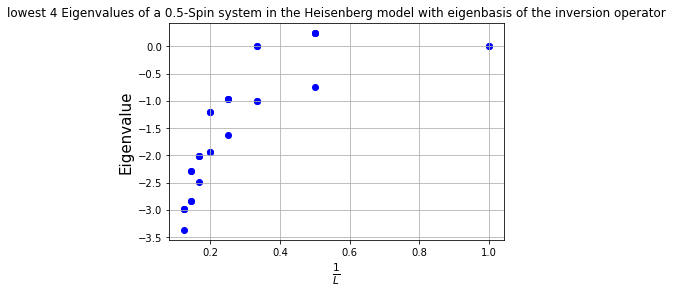

In [9]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
J = 1
s = 0.5

n = 8

measureTime = []
times = []
Length = []

ks = [0,1] 

for L in range(1,n+1):
    start = timer()
    Basis = genBasis(L,s)
    allEvalues = []
    for k in ks:
        matrix = calcMatrixInversionsymmetrie(Basis, J, L, s, inversionOperator, k)
        Evalues = np.linalg.eigvals(matrix)
        allEvalues = np.append(allEvalues, Evalues, axis = 0)
    if len(allEvalues) >= 4: # print the lowest 4 Eigenvalues
        plt.scatter([1/L]*4, np.sort(allEvalues)[:4], color = "blue")
    else:
        plt.scatter([1/L]*len(allEvalues), np.sort(allEvalues), color = "blue")
    times.append(timer() - start)
    Length.append(L)


measureTime.append([Length, times])
times = []
Length = []

plt.title(f"lowest 4 Eigenvalues of a {s}-Spin system in the Heisenberg model with eigenbasis of the inversion operator")
plt.xlabel(r"$\frac{1}{L}$", fontsize = 15)
plt.ylabel("Eigenvalue", fontsize = 15)
plt.grid()
plt.show()


## Exercise 10

/tmp/ipykernel_8387/1177628638.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  Matrix[i,j] +=  2*np.exp(np.pi*k*1j)*(Hamiltonian(J, normalizable[i], L, operator(normalizable[j]), s)  /


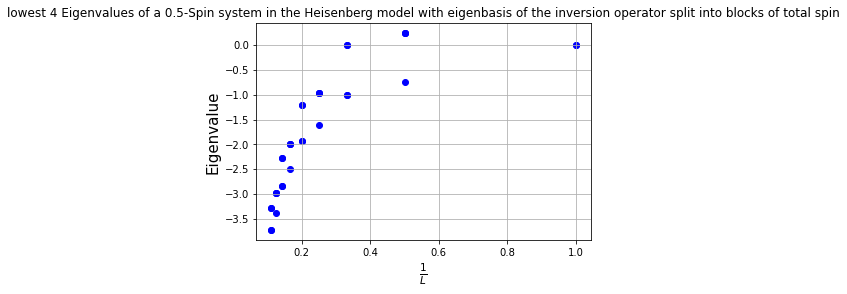

In [10]:

n = n + 1

for L in range(1,n+1):
    start = timer()
    splitBasis = splitBasisTotZ(genBasis(L,s),L)
    allEvalues = []
    for basis in splitBasis:
        for k in ks:
            matrix = calcMatrixInversionsymmetrie(basis, J, L, s, inversionOperator, k)
            Evalues = np.linalg.eigvals(matrix)
            allEvalues = np.append(allEvalues, Evalues, axis = 0)
    if len(allEvalues) >= 4: # print the lowest 4 Eigenvalues
        plt.scatter([1/L]*4, np.sort(allEvalues)[:4], color = "blue")
    else:
        plt.scatter([1/L]*len(allEvalues), np.sort(allEvalues), color = "blue")
    times.append(timer() - start)
    Length.append(L)

measureTime.append([Length, times])
times = []
Length = []

plt.title(f"lowest 4 Eigenvalues of a {s}-Spin system in the Heisenberg model with eigenbasis of the inversion operator split into blocks of total spin")
plt.xlabel(r"$\frac{1}{L}$", fontsize = 15)
plt.ylabel("Eigenvalue", fontsize = 15)
plt.grid()
plt.show()